# Helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def Gau_seq(T, r, sd1, sd2, loc = 0):
    """
    Generate a sequence of Gaussian variables of length T.
    
    :param T: length of sequence
    :param r: ratio of outliers
    :param sd1: standard deviation of inliers
    :param sd2: standard deviation of outliers
    :param loc: mean of outliers
    
    :return: a numpy vector of data
    
    """
    #Indicators with z = 1 for outliers
    z = np.random.uniform(0, 1, T) < r
    
    #Generate the sequence
    seq = np.random.normal(0, sd1, T) * (1 - z) + np.random.normal(loc, sd2, T) * z
    
    return(seq, z)
            
    

In [2]:
def Test(seq, alpha = 0.05):
    """
    Test if Y_T is an outlier. Under null hypothesis, we know 
        |Y_T| \le Q_{1 - \alpha}(|Y_1|, \dots, Y_T)
        
    We return TURE is Y_T is an outlier
    """
    abs_seq = abs(seq)
    
    comparison = abs_seq < abs_seq[-1]
    
    return( sum(comparison) > (1 - alpha) * len(seq) )

# Part(a)

Does the presence of outlier(s) before time $t$, tend to cause us to be more conservative or less conservative for detecting an outlier at time $t$, in practice?

In [3]:
def part_a(T = 100, r = 0.2, sd1 = 1, sd2 = 3, loc = 0, seed = 123, N = 100):
    """
    Do experiments for N times and to the type 1 and type 2 error of our testing under
    the presence of outliers.
    
    :param T: length of sequence
    :param r: ratio of outliers
    :param sd1: standard deviation of inliers
    :param sd2: standard deviation of outliers
    :param loc: mean of outliers
    :param seed: a random seet
    :param N: number of repeated trials
    """
    np.random.seed(seed)
    
    results_out = np.zeros(N)
    results_in = np.zeros(N)
    
    for i in range(0, N):
        #Generate a sequence
        X, z = Gau_seq(T, r, sd1, sd2, loc)
        #Add an outlier
        outlier = np.random.normal(loc, sd2, 1)
        X = np.append(X, outlier)
        results_out[i] = Test(X)
    
    for i in range(0, N):
        #Generate a sequence
        X, z = Gau_seq(T, r, sd1, sd2, loc)
        #Add an inlier
        inlier = np.random.normal(0, sd1, 1)
        X = np.append(X, inlier)
        results_in[i] = Test(X)
    
    return(sum(results_out)/N, sum(results_in)/N )
    
    

In [4]:
#Set different sd2 for outliers
sd2 = np.arange(0, 5.1, 0.1)
Power = np.zeros(len(sd2))
TypeI = np.zeros(len(sd2))

In [5]:
for i in range(0, len(sd2)):
    Power[i], TypeI[i] = part_a(T = 100, r = 0.2, sd1 = 1, sd2 = sd2[i], 
                                loc = 0, N = 100, seed =123)
    
    if i % 5 == 0:
        print( str(i / len(sd2) * 100) + "%" )

0.0%
9.803921568627452%
19.607843137254903%
29.411764705882355%
39.21568627450981%
49.01960784313725%
58.82352941176471%
68.62745098039215%
78.43137254901961%
88.23529411764706%
98.0392156862745%


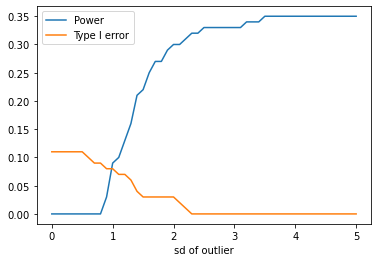

In [6]:
plt.plot(sd2, Power, label = "Power")
plt.plot(sd2, TypeI, label = "Type I error")
plt.xlabel("sd of outlier")

plt.legend();

# Part(b)

Are there ways to modify the procedure (i.e., the method of applying conformal prediction in a streaming way), to reduce any problems you've identified? For example, what if we try dropping any outliers -- say, if we reject at time ii and flag ($X_i$,$Y_i$) as an outlier, can we then drop this data point for future tests, like at time $i+1$ we compare ($X_{i+1},Y_{i+1}$)
 against $(X_1,Y_1),...,(X_{i-1},Y_{i-1})$? Would this "dropping" modification fix the problem, or might it introduce new issues?



Suppose we want to test if $X_{T+1}$ is an outlier. We implememnt this method and check its average performance under two scenarios:
1. No outliers
2. 20% of the data are outliers

In [7]:
def part_b(T = 100, r = 0.2, sd1 = 1, sd2 = 3, loc = 0, seed = 123, N = 100):
    """
    Do experiments for N times and to the type 1 and type 2 error of our testing under
    the presence of outliers.
    
    :param T: length of sequence
    :param r: ratio of outliers
    :param sd1: standard deviation of inliers
    :param sd2: standard deviation of outliers
    :param loc: mean of outliers
    :param seed: a random seet
    :param N: number of repeated trials
    """
    np.random.seed(seed)
    
    results_in = np.zeros(N)
    results_out = np.zeros(N)
    for i in range(0, N):
        #Generate a sequence
        X, z = Gau_seq(T + 1, r, sd1, sd2, loc)
        
        seq = np.array([X[0]]) #The data before time T that we do not drop
        for t in range(0, T):
            temp_seq = np.append(seq, X[t])
            if not Test(temp_seq):
                seq = temp_seq
        #Add an outlier
        outlier = np.random.normal(loc, sd2, 1)
        seq = np.append(seq, outlier)
        results_out[i] = Test(seq)
        
    for i in range(0, N):
        #Generate a sequence
        X, z = Gau_seq(T + 1, r, sd1, sd2, loc)
        
        seq = np.array([X[0]]) #The data before time T that we do not drop
        for t in range(0, T):
            temp_seq = np.append(seq, X[t])
            if not Test(temp_seq):
                seq = temp_seq
        #Add an inlier
        inlier = np.random.normal(0, sd1, 1)
        seq = np.append(seq, inlier)
        results_in[i] = Test(seq)

    
    return(sum(results_out)/N, sum(results_in)/N )

In [8]:
Ts = np.arange(50, 550, 50)
Power = np.zeros(len(Ts))
TypeI = np.zeros(len(Ts))

In [9]:
#Case when 20% of data are outliers
for i in range(0, len(Ts)):
    Power[i], TypeI[i] = part_b(T = Ts[i], r = 0.2, sd1 = 1, sd2 = 3, 
                                loc = 0, N = 100, seed =123)
    print( str(i / len(Ts) * 100) + "%" )

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


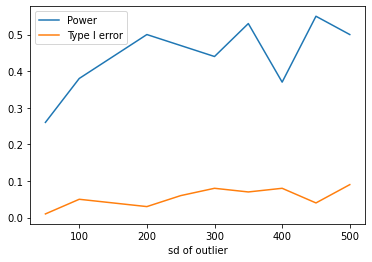

In [10]:
plt.plot(Ts, Power, label = "Power")
plt.plot(Ts, TypeI, label = "Type I error")
plt.xlabel("sd of outlier")
plt.legend();


In [11]:
#Also look at method without dropping data
for i in range(0, len(Ts)):
    Power[i], TypeI[i] = part_a(T = Ts[i], r = 0.2, sd1 = 1, sd2 = 3, 
                                loc = 0, N = 100, seed =123)
    print( str(i / len(Ts) * 100) + "%" )

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


Text(0.5, 0, 'sd of outlier')

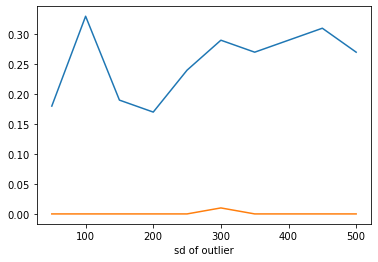

In [12]:
plt.plot(Ts, Power, label = "Power")
plt.plot(Ts, TypeI,  label = "Type I error")
plt.xlabel("sd of outlier")

In [ ]:
#Case when  0% of data are outliers
for i in range(0, len(Ts)):
    Power[i], TypeI[i] = part_b(T = Ts[i], r = 0, sd1 = 1, sd2 = 3, 
                                loc = 0, N = 100, seed =123)
    print( str(i / len(Ts) * 100) + "%" )

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%


In [ ]:
plt.plot(Ts, Power, label = "Power")
plt.plot(Ts, TypeI, label = "Type I error")
plt.xlabel("sd of outlier")
plt.legend();


In [ ]:
#Also look at method without dropping data
for i in range(0, len(Ts)):
    Power[i], TypeI[i] = part_a(T = Ts[i], r = 0, sd1 = 1, sd2 = 3, 
                                loc = 0, N = 100, seed =123)
    print( str(i / len(Ts) * 100) + "%" )

In [ ]:
plt.plot(Ts, Power, label = "Power")
plt.plot(Ts, TypeI, label = "Type I error")
plt.legend();
